In [57]:
import os
import numpy as np
import sciann as sn 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [58]:
PATH_NAME_DON = "PI_DeepONet_Laplace"
PATH_NAME_ENDON = "PI_EnDeepONet_Laplace"

In [59]:
x_source_red = [-0.5, 0.0, 0.5]
y_source_red = [-0.5, 0.0, 0.5]
ref_data = {}
for f in os.listdir('data'):
    i, j = [int(x) for x in f.split('.txt')[0].split('comsol_')[-1].split('_')]
    data = np.loadtxt(os.path.join('data', f), delimiter=',')
    ref_data[(x_source_red[i], y_source_red[j])] = {
        'x': data[:, 0],
        'y': data[:, 1],
        'u': data[:, 2]
    }
    print(i, j, data.shape)

1 2 (10000, 3)
1 0 (10000, 3)
1 1 (10000, 3)
0 0 (10000, 3)
2 2 (10000, 3)
0 1 (10000, 3)
2 1 (10000, 3)
2 0 (10000, 3)
0 2 (10000, 3)


In [60]:
from pyDOE import *

def lhs_uniform(d, n, bb = None):
    samples = lhs(d, n)
    if not bb:
        bb = [[0, 1] for i in range(d)]
    data = []
    for i, bb_i, in zip(range(d), bb):
        data.append(
            bb_i[0] + (bb_i[1]-bb_i[0]) * samples[:, i]
        )
    return data if len(data)>1 else data[0]

In [61]:
SENSOR_SIZE = 1
SOURCE_RADI = 0.1

In [62]:
from tensorflow.keras.utils import Sequence 


class DataGenerator(Sequence):
    def __init__(self, sample_size = 100, 
                       batch_size = dict(domain=1000, bc=100),
                       sensor_size = 10,
                       source_radius = 0.1,
                       shuffle = True,
                       domain = dict(x = [-1, 1], y = [-1, 1]),
                       seed=1234):
        # generate data
        self._radius = source_radius
        self._xmin, self._xmax = domain['x']
        self._ymin, self._ymax = domain['y']
        self._sample_size = sample_size
        self._batch_size = batch_size
        self._sensor_size = sensor_size
        self._shuffle = shuffle
        self._set_data(sample_size, batch_size)
        
    @property
    def batch_size(self):
        return self._batch_size

    def __len__(self):
        return self._sample_size

    def __getitem__(self, index):
        idx = self._sample_ids[index]
        return self.inputs[idx], self.targets[idx], self.sample_weights[idx]

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._sample_ids)

    def _set_data(self, num_sample, batch_size):
        inputs, targets, sample_weights = [], [], []
        num_source_1d = int(np.sqrt(num_sample+1e-6))
        grid_x = np.linspace(self._xmin, self._xmax, num_source_1d+2)[1:-1] # del boundary nodes
        grid_y = np.linspace(self._ymin, self._ymax, num_source_1d+2)[1:-1] # del boundary nodes
        x_source, y_source = [x.flatten() for x in np.meshgrid(grid_x, grid_y)]
        for xs, ys in zip(x_source, y_source):
            inputs_i, targets_i, sample_weights_i = self.__generate_batch_data(xs, ys, batch_size)
            inputs.append(inputs_i)
            targets.append(targets_i)
            sample_weights.append(sample_weights_i)
        # concat data
        self.inputs = inputs
        self.targets = targets
        self.sample_weights = sample_weights
        self._sample_ids = np.arange(num_sample)
        # return inputs, targets, sample_weights

    def __generate_batch_data(self, x_source, y_source, batch_size):
        counter = 0

        # sample domain
        x_dom, y_dom = lhs_uniform(2, batch_size['domain'],
                                   [[self._xmin, self._xmax], [self._ymin, self._ymax]])
        ids_dom = np.arange(batch_size['domain'])
        counter += ids_dom.size

        # Sample BC
        # edge 1
        x_bc = np.concatenate(
            [np.linspace(self._xmin, self._xmax, batch_size['bc']),
             np.linspace(self._xmin, self._xmax, batch_size['bc']),
             np.linspace(self._xmin, self._xmin, batch_size['bc']),
             np.linspace(self._xmax, self._xmax, batch_size['bc'])]
        )
        y_bc = np.concatenate(
            [np.linspace(self._ymin, self._ymin, batch_size['bc']),
             np.linspace(self._ymax, self._ymax, batch_size['bc']),
             np.linspace(self._ymin, self._ymax, batch_size['bc']),
             np.linspace(self._ymin, self._ymax, batch_size['bc'])]
        )
        ids_bc = np.arange(batch_size['bc']*4) + counter
        counter += ids_bc.size

        size_sample = counter
        
        # trunk inputs
        x_trunk = np.hstack([x_dom, x_bc]).reshape(-1,1)
        y_trunk = np.hstack([y_dom, y_bc]).reshape(-1,1)
        
        # branch inputs
        x_branch = np.tile([x_source], (size_sample, 1))
        y_branch = np.tile([y_source], (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, x_branch, y_branch]
        targets, sample_weights = [], []
        for idx in [ids_dom, ids_bc]:
            wi = np.zeros(size_sample)
            wi[idx] = size_sample / idx.size
            sample_weights.append(wi)
            targets.append(np.zeros((size_sample, 1)))
        
        return inputs, targets, sample_weights
    
    
    def generate_test_data(self, Xs, Ys, X_coord, Y_coord, sensor_size=10):
        counter = 0

        # sample domain
        # mesh_grid = np.meshgrid(np.linspace(self._xmin,self._xmax,Nx),
        #                         np.linspace(self._ymin,self._ymax,Ny))
        # x_trunk, y_trunk = [x.reshape(-1,1) for x in mesh_grid]
        x_trunk, y_trunk = X_coord.reshape(-1,1), Y_coord.reshape(-1,1)
        size_sample = len(x_trunk)

        # branch inputs
        x_branch = np.tile([Xs], (size_sample, 1))
        y_branch = np.tile([Ys], (size_sample, 1))

        # inputs
        inputs = [x_trunk, y_trunk, x_branch, y_branch]
        
        return inputs


In [63]:
sn.reset_session()
sn.set_random_seed(1234)

In [64]:
# Define the model
class PI_DeepONet:
    def __init__(self, sensor_size=1, embedding_size=20, branch_layers=7*[20], trunk_layers=7*[20], actf='tanh'):
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, actf)
        
        self.branch_inputs = [sn.Variable('xb', units=sensor_size),
                              sn.Variable('yb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, branch_layers, actf, 'linear')
        
        self.output = sn.rename(sn.dot(self.branch, self.trunk), 'u')
        
        d2u_dx2 = sn.diff(self.output, self.trunk_inputs[0], order=2)
        d2u_dy2 = sn.diff(self.output, self.trunk_inputs[1], order=2)
        
        source = sn.exp(-((self.trunk_inputs[0] - self.branch_inputs[0])**2 +
                          (self.trunk_inputs[1] - self.branch_inputs[1])**2) / SOURCE_RADI)
        eikonal = sn.rename(d2u_dx2 + d2u_dy2 + source, 'laplace')
        bc = sn.rename(self.output*1.0, 'source')

        self.losses = [eikonal, bc]

        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs, self.losses, optimizer='adam')
    
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=1e-3,
                             final_learning_rate=5e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            target_weights=[0.2, 1],
            save_weights={"path": os.path.join(PATH_NAME_DON, "weights"), "freq": 100}
        )
        return self.history

    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [65]:
# Define the model
class PI_EnDeepONet:
    def __init__(self, sensor_size=1, embedding_size=20, branch_layers=7*[20], trunk_layers=7*[20], root_layers=[50, 25], actf='tanh'):
        # Network initialization and evaluation functions
        self.trunk_inputs = [sn.Variable('xt'), sn.Variable('yt')]
        self.trunk_embedding = sn.Field('trunk', units=embedding_size)
        self.trunk = sn.Functional(self.trunk_embedding, self.trunk_inputs, trunk_layers, actf, actf)
        
        self.branch_inputs = [sn.Variable('xb', units=sensor_size),
                              sn.Variable('yb', units=sensor_size)]
        self.branch_embedding = sn.Field('branch', units=embedding_size)
        self.branch = sn.Functional(self.branch_embedding, self.branch_inputs, branch_layers, actf, 'linear')
        
        e1 = self.trunk * self.branch
        e1 = sn.rename(self.trunk * self.branch, 'e1')
        e2 = self.trunk - self.branch
        e2 = sn.rename(e2, 'e2')
        e3 = self.trunk + self.branch
        e3 = sn.rename(e3, 'e3')
        
        self.output = sn.Functional('u', [e1, e2, e3], root_layers, 'tanh')
        
        d2u_dx2 = sn.diff(self.output, self.trunk_inputs[0], order=2)
        d2u_dy2 = sn.diff(self.output, self.trunk_inputs[1], order=2)
        
        source = sn.exp(-((self.trunk_inputs[0] - self.branch_inputs[0])**2 +
                          (self.trunk_inputs[1] - self.branch_inputs[1])**2) / SOURCE_RADI)
        eikonal = sn.rename(d2u_dx2 + d2u_dy2 + source, 'laplace')
        bc = sn.rename(self.output*1.0, 'source')

        self.losses = [eikonal, bc]

        self.model = sn.SciModel(self.trunk_inputs + self.branch_inputs, self.losses, optimizer='adam')
    
    def eval(self, inputs):
        return self.model(inputs)

    def eval_u(self, inputs):
        return self.output.eval(self.model, inputs)
    
    def train(self, data_generator, epochs=200, verbose=1):
        batch_size = data_generator.batch_size
        learning_rate = dict(scheduler="exponential_decay", 
                             initial_learning_rate=1e-3,
                             final_learning_rate=5e-5,
                             delay_epochs=1000,
                             decay_epochs=10000)
        self.history = self.model.train(
            data_generator,
            epochs=epochs, 
            batch_size=batch_size, 
            verbose=verbose, 
            learning_rate=learning_rate,
            target_weights=[0.2, 1],
            save_weights={"path": os.path.join(PATH_NAME_ENDON, "weights"), "freq": 100}
        )
        return self.history

    def plot_loss(self):
        loss = self.history.history["loss"]
        plt.semilogy(np.array(loss) / loss[0], label="total_loss")
        plt.legend()
        plt.show()

In [66]:
dg = DataGenerator(
    sample_size=25,
    batch_size={'domain': 2000, 'bc':100},
    sensor_size=SENSOR_SIZE,
    source_radius=SOURCE_RADI
)

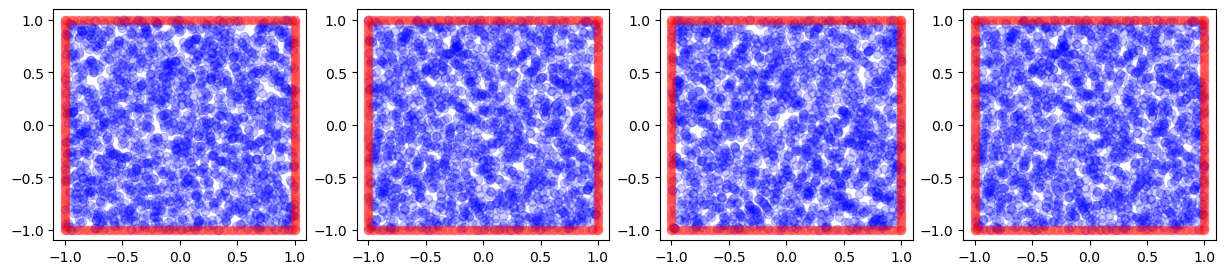

In [67]:

from itertools import cycle

n_plot = 4
fig, ax = plt.subplots(1, n_plot, figsize=(15, 3))
for i in range(n_plot):
    cycol = cycle('brycmg')
    inputs, targets, weights = dg[np.random.choice(len(dg))]
    for wi in weights:
        x_trunk, y_trunk, x_branch, y_branch = inputs
        idx = wi > 0
        ax[i].scatter(x_trunk[idx], y_trunk[idx], color=next(cycol), alpha=0.2)

plt.show()

In [68]:
DON = PI_DeepONet(
    sensor_size=SENSOR_SIZE,
    embedding_size=50,
    branch_layers=5*[50],
    trunk_layers=5*[50]
)
DON.model.load_weights(os.path.join(PATH_NAME_DON, "weights-end.hdf5"))
DON.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xb (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 yb (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 concat_18 (Concatenate)        (None, 2)            0           ['xb[0][0]',                     
                                                                  'yb[0][0]']                     
                                                                                                  
 D50b_54 (Dense)                (None, 50)           150         ['concat_18[0][0]']          

In [69]:
EnDON = PI_EnDeepONet(
    sensor_size=SENSOR_SIZE,
    embedding_size=50,
    branch_layers=1*[50],
    trunk_layers=1*[50],
    root_layers=[50, 20]
)
EnDON.model.load_weights(os.path.join(PATH_NAME_ENDON, "weights-end.hdf5"))
EnDON.model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xt (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 yt (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 concat_19 (Concatenate)        (None, 2)            0           ['xt[0][0]',                     
                                                                  'yt[0][0]']                     
                                                                                                  
 xb (InputLayer)                [(None, 1)]          0           []                         

In [70]:
def cust_pcolor(AX, X, Y, P, Xs=None, Ys=None, left_title=None, top_title=None, cmap='jet', vmin=None, vmax=None, xlabel=False, ylabel=False):
    ax1 = AX.pcolor(X, Y, P, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(ax1, ax=AX)
    if isinstance(Xs, np.ndarray) and isinstance(Ys, np.ndarray):
        AX.plot(Xs, Ys, color='r')
    AX.set_xticks(np.linspace(-1, 1, 5))
    AX.set_yticks(np.linspace(-1, 1, 5))
    if xlabel: 
        AX.set_xlabel('X (km)')
    if ylabel and left_title:
        AX.set_ylabel(left_title + '\n\n' + 'Y (km)')
    elif ylabel:
        AX.set_ylabel('Y (km)')
    if top_title:
        AX.set_title(top_title)

Saving to:  field_results.png


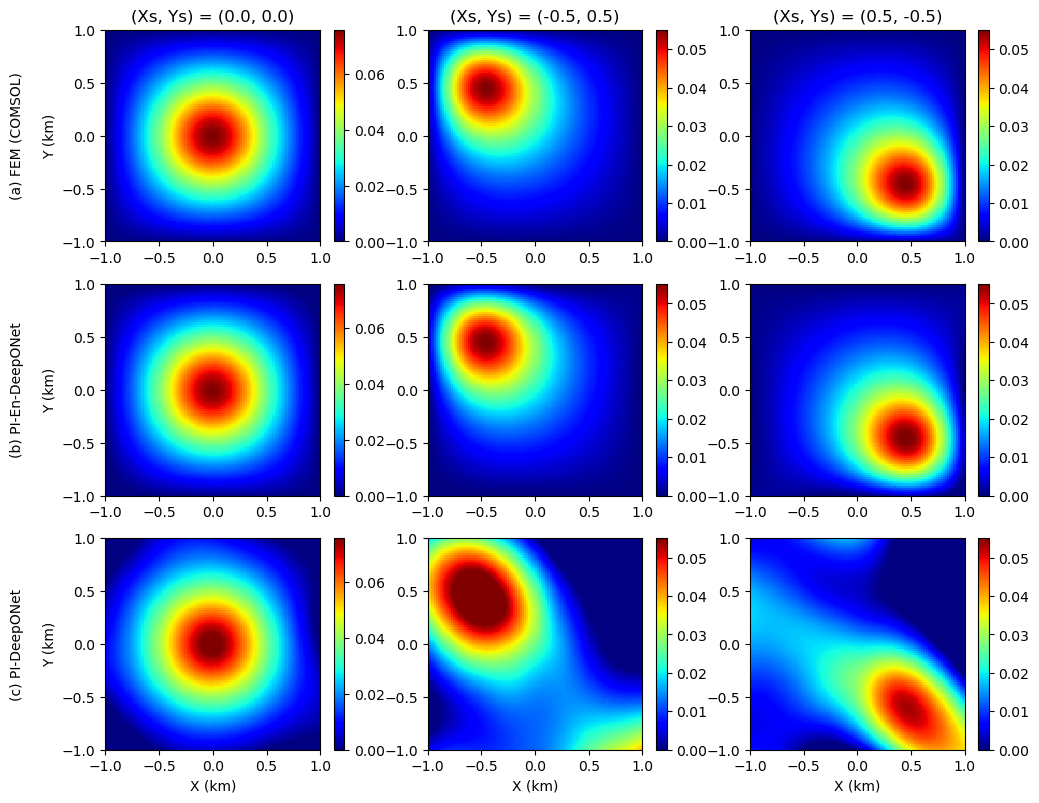

In [74]:
x_source = [0.0, -0.5, 0.5] # del boundary nodes
y_source = [0.0, 0.5, -0.5] # del boundary nodes

mse_error = []

fig, ax = plt.subplots(3, 3, figsize=(11, 9))
for ii, (Xs, Ys) in enumerate(zip(x_source, y_source)):
    r = dg._radius
    key = (Xs, Ys)
    X_coord, Y_coord = ref_data[key]['x'], ref_data[key]['y']
    
    test_data = dg.generate_test_data(Xs, Ys, X_coord, Y_coord, sensor_size=SENSOR_SIZE)
    
    Nx = Ny = int(np.sqrt(len(X_coord)))
    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    
    exact = ref_data[key]['u'].reshape(Nx, Ny)

    x_test = test_data[0].reshape(Nx, Ny)
    y_test = test_data[1].reshape(Nx, Ny)
    
    pred = EnDON.eval_u(test_data).reshape(Nx, Ny)
    mse_error.append(np.mean((pred - exact)**2))
    pred_don = DON.eval_u(test_data).reshape(Nx, Ny)

    error = np.abs(exact - pred) / exact.max() * 100
    
    vmin, vmax = 0., exact.max()

    cust_pcolor(ax[0, ii], x_test, y_test, exact,
                Xs=test_data[2][0, :], Ys=test_data[3][0, :],
                cmap='jet', 
                left_title='(a) FEM (COMSOL)' if ii==0 else None,
                top_title='(Xs, Ys) = ({}, {})'.format(Xs, Ys),
                xlabel=False,
                ylabel=True if ii==0 else False,
                vmin=vmin, vmax=vmax)
    
    cust_pcolor(ax[1, ii], x_test, y_test, pred,
                Xs=test_data[2][0, :], Ys=test_data[3][0, :],
                cmap='jet',
                left_title='(b) PI-En-DeepONet' if ii==0 else None, 
                xlabel=False,
                ylabel=True if ii==0 else False,
                vmin=vmin, vmax=vmax)

    cust_pcolor(ax[2, ii], x_test, y_test, pred_don,
                Xs=test_data[2][0, :], Ys=test_data[3][0, :],
                cmap='jet',
                left_title='(c) PI-DeepONet' if ii==0 else None, 
                xlabel=True,
                ylabel=True if ii==0 else False,
                 vmin=vmin, vmax=vmax
                )

plt.subplots_adjust(0.12, 0.1, 0.95, 0.9, 0.2, 0.2)
print('Saving to: ', os.path.join('field_results.png'))
plt.savefig(os.path.join('field_results.png'), dpi=300)
plt.show()

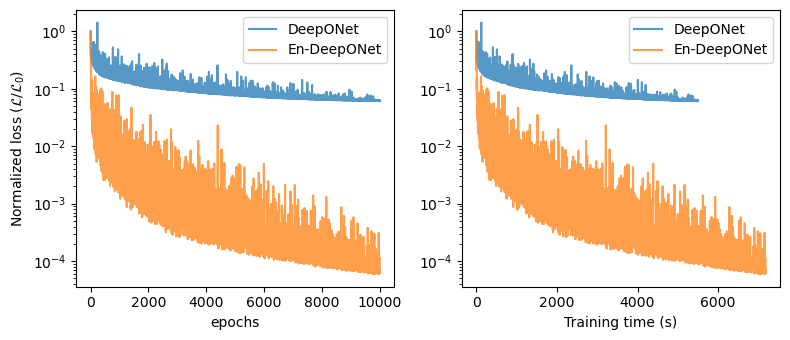

In [72]:
path_to_losses = [
    os.path.join(PATH_NAME_DON, "loss_history.csv"),
    os.path.join(PATH_NAME_ENDON, "loss_history.csv"),
]

fig, ax = plt.subplots(1,2,figsize=(8,3.5))
for f, label in zip(path_to_losses, ["DeepONet", "En-DeepONet"]):
    df = pd.read_csv(f)
    loss_val = np.array(df['loss'])/df['loss'][0]
    ax[0].semilogy(loss_val, alpha=0.75, label=label)
    ax[1].semilogy(np.cumsum(df['time']), loss_val, alpha=0.75, label=label)

ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Normalized loss ($\mathcal{L}/\mathcal{L}_0$)')
ax[1].set_xlabel('Training time (s)')
ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig('loss_results.pdf')